In [2]:
pip install jsonpickle

Note: you may need to restart the kernel to use updated packages.


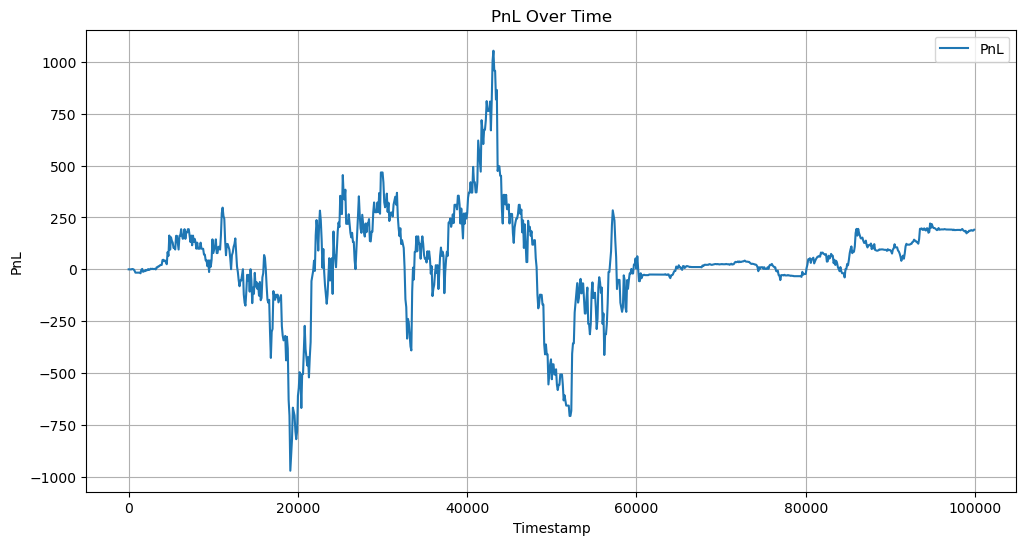

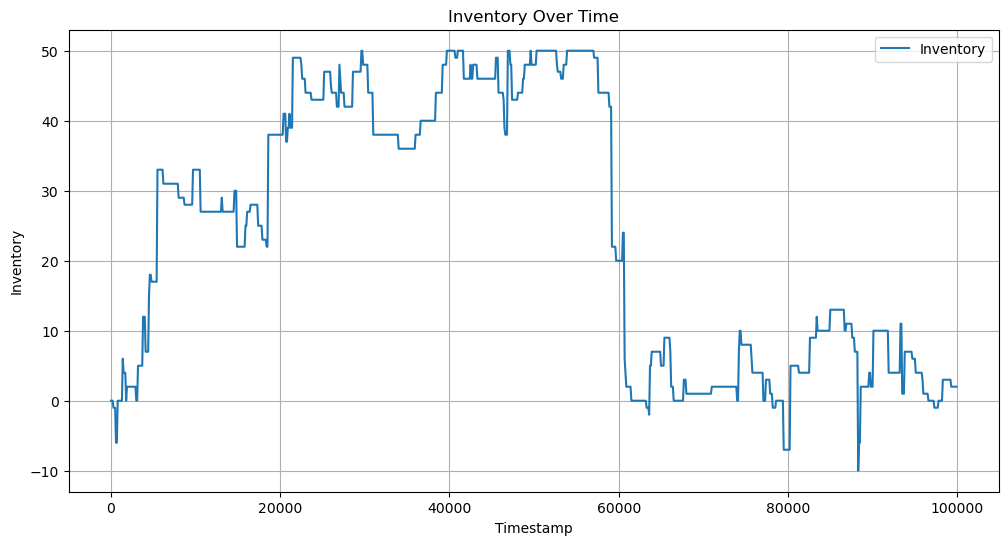

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datamodel import OrderDepth, Order, TradingState
from tryout import Trader, Product  # <-- Change 'your_trader_file' to the name of your trader file

# 1. Load Data
df = pd.read_csv('Dati.csv', sep=';')

# 2. Initialize Trader
trader = Trader()

# 3. Initialize Tracking Variables
position = {Product.SQUID_INK: 0}
cash = 0
pnl_history = []
inventory_history = []
timestamps = []

# 4. Run Backtest
for idx, row in df[df['product'] == 'SQUID_INK'].iterrows():  # Only trading SQUID_INK

    # Build the OrderBook (OrderDepth)
    order_depth = OrderDepth()

    # Add buy orders (bids)
    if not np.isnan(row['bid_price_1']):
        order_depth.buy_orders[row['bid_price_1']] = row['bid_volume_1']
    if not np.isnan(row['bid_price_2']):
        order_depth.buy_orders[row['bid_price_2']] = row['bid_volume_2']
    if not np.isnan(row['bid_price_3']):
        order_depth.buy_orders[row['bid_price_3']] = row['bid_volume_3']

    # Add sell orders (asks)
    if not np.isnan(row['ask_price_1']):
        order_depth.sell_orders[row['ask_price_1']] = -row['ask_volume_1']
    if not np.isnan(row['ask_price_2']):
        order_depth.sell_orders[row['ask_price_2']] = -row['ask_volume_2']
    if not np.isnan(row['ask_price_3']):
        order_depth.sell_orders[row['ask_price_3']] = -row['ask_volume_3']

    # Build the TradingState
    state = TradingState(
        traderData="",
        timestamp=row['timestamp'],
        listings={},
        order_depths={Product.SQUID_INK: order_depth},
        own_trades={},
        market_trades={},
        position=position,
        observations={},
    )

    # Get the Trader's Orders
    orders, conversions, traderData = trader.run(state)

    # 5. Execute Orders
    for order in orders.get(Product.SQUID_INK, []):
        if order.quantity > 0:
            # BUY order: Cross with current sell side (ask)
            best_ask = min(order_depth.sell_orders.keys())
            if order.price >= best_ask:  # Aggressive enough
                quantity_filled = min(order.quantity, -order_depth.sell_orders[best_ask])
                execution_price = best_ask
                position[Product.SQUID_INK] += quantity_filled
                cash -= execution_price * quantity_filled
        elif order.quantity < 0:
            # SELL order: Cross with current buy side (bid)
            best_bid = max(order_depth.buy_orders.keys())
            if order.price <= best_bid:  # Aggressive enough
                quantity_filled = min(-order.quantity, order_depth.buy_orders[best_bid])
                execution_price = best_bid
                position[Product.SQUID_INK] -= quantity_filled
                cash += execution_price * quantity_filled

    # 6. Mark-to-Market PnL
    mid_price = row['mid_price']
    current_pnl = cash + position[Product.SQUID_INK] * mid_price
    pnl_history.append(current_pnl)
    inventory_history.append(position[Product.SQUID_INK])
    timestamps.append(row['timestamp'])

# 7. Plot Results
plt.figure(figsize=(12, 6))
plt.plot(timestamps, pnl_history, label='PnL')
plt.title('PnL Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(timestamps, inventory_history, label='Inventory')
plt.title('Inventory Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()

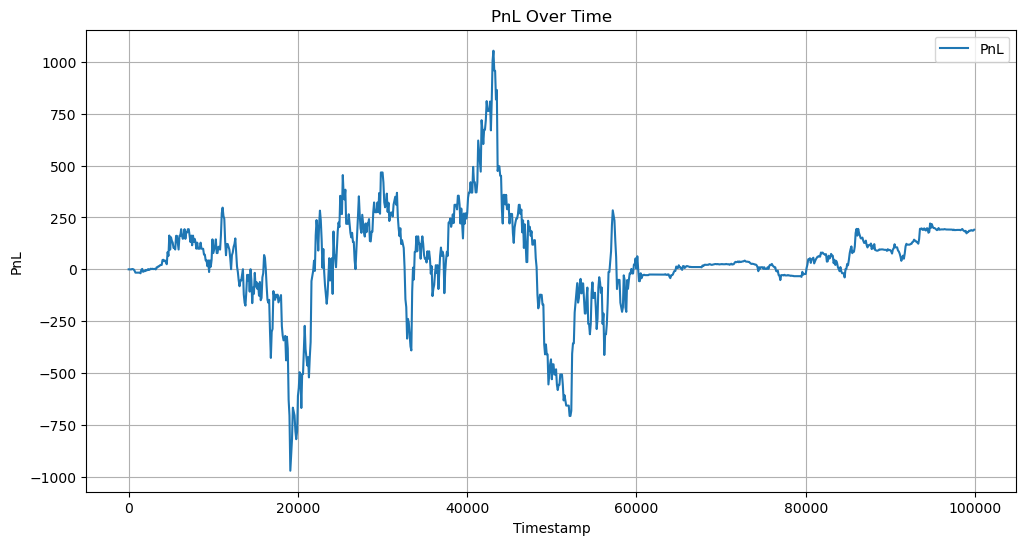

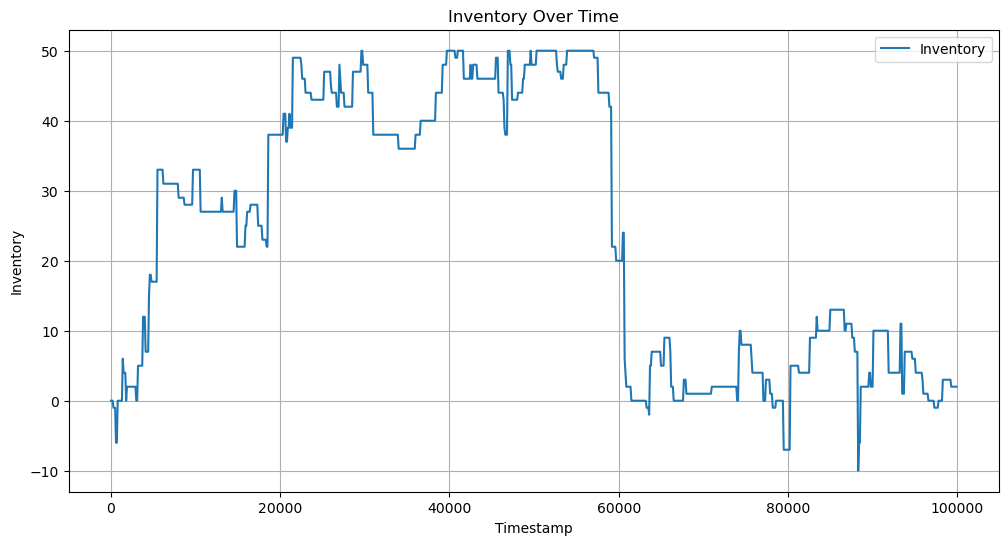

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import jsonpickle
from datamodel import OrderDepth, Order, TradingState

# ========== PARAMETER SECTION ========== #

# Backtest parameters (easy to modify)
SQUID_INK_make_width = 3.5
SQUID_INK_take_width = 1
SQUID_INK_position_limit = 50
SQUID_INK_market_make_offset = 1  # <-- This is the +1 / -1 shift you talked about

# Data file
DATA_FILE = 'Dati.csv'

# ======================================== #

class Product:
    SQUID_INK = "SQUID_INK"

class Trader:
    def __init__(self):
        self.SQUID_INK_prices = []
        self.SQUID_INK_vwap = []
        self.LIMIT = {Product.SQUID_INK: SQUID_INK_position_limit}

    def take_best_orders(self, product, fair_value, take_width, orders, order_depth, position, buy_order_volume, sell_order_volume):
        position_limit = self.LIMIT[product]
        if len(order_depth.sell_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_ask_amount = -order_depth.sell_orders[best_ask]
            if best_ask <= fair_value - take_width:
                quantity = min(best_ask_amount, position_limit - position)
                if quantity > 0:
                    orders.append(Order(product, best_ask, quantity))
                    buy_order_volume += quantity

        if len(order_depth.buy_orders) != 0:
            best_bid = max(order_depth.buy_orders.keys())
            best_bid_amount = order_depth.buy_orders[best_bid]
            if best_bid >= fair_value + take_width:
                quantity = min(best_bid_amount, position_limit + position)
                if quantity > 0:
                    orders.append(Order(product, best_bid, -quantity))
                    sell_order_volume += quantity

        return buy_order_volume, sell_order_volume

    def market_make(self, product, orders, bid, ask, position, buy_order_volume, sell_order_volume):
        buy_quantity = self.LIMIT[product] - (position + buy_order_volume)
        sell_quantity = self.LIMIT[product] + (position - sell_order_volume)

        if buy_quantity > 0:
            orders.append(Order(product, bid, buy_quantity))
        if sell_quantity > 0:
            orders.append(Order(product, ask, -sell_quantity))

        return buy_order_volume, sell_order_volume

    def clear_position_order(self, product, fair_value, orders, order_depth, position, buy_order_volume, sell_order_volume):
        fair_bid = math.floor(fair_value)
        fair_ask = math.ceil(fair_value)

        if position + buy_order_volume - sell_order_volume > 0:
            if fair_ask in order_depth.buy_orders:
                clear_quantity = min(order_depth.buy_orders[fair_ask], position)
                if clear_quantity > 0:
                    orders.append(Order(product, fair_ask, -clear_quantity))
                    sell_order_volume += clear_quantity

        if position + buy_order_volume - sell_order_volume < 0:
            if fair_bid in order_depth.sell_orders:
                clear_quantity = min(-order_depth.sell_orders[fair_bid], -position)
                if clear_quantity > 0:
                    orders.append(Order(product, fair_bid, clear_quantity))
                    buy_order_volume += clear_quantity

        return buy_order_volume, sell_order_volume

    def SQUID_INK_orders(self, order_depth, timespan, width, take_width, position):
        orders = []
        buy_order_volume = 0
        sell_order_volume = 0

        if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_bid = max(order_depth.buy_orders.keys())

            filtered_ask = [p for p in order_depth.sell_orders if abs(order_depth.sell_orders[p]) >= 15]
            filtered_bid = [p for p in order_depth.buy_orders if abs(order_depth.buy_orders[p]) >= 15]
            mm_ask = min(filtered_ask) if filtered_ask else best_ask
            mm_bid = max(filtered_bid) if filtered_bid else best_bid

            mmmid_price = (mm_ask + mm_bid) / 2
            self.SQUID_INK_prices.append(mmmid_price)
            if len(self.SQUID_INK_prices) > timespan:
                self.SQUID_INK_prices.pop(0)

            fair_value = mmmid_price

            buy_order_volume, sell_order_volume = self.take_best_orders(
                Product.SQUID_INK, fair_value, take_width, orders, order_depth, position, buy_order_volume, sell_order_volume
            )

            buy_order_volume, sell_order_volume = self.clear_position_order(
                Product.SQUID_INK, fair_value, orders, order_depth, position, buy_order_volume, sell_order_volume
            )

            # Offset Control
            aaf = [p for p in order_depth.sell_orders if p > fair_value + SQUID_INK_market_make_offset]
            bbf = [p for p in order_depth.buy_orders if p < fair_value - SQUID_INK_market_make_offset]
            baaf = min(aaf) if aaf else fair_value + 2
            bbbf = max(bbf) if bbf else fair_value - 2

            buy_order_volume, sell_order_volume = self.market_make(
                Product.SQUID_INK, orders, bbbf + SQUID_INK_market_make_offset, baaf - SQUID_INK_market_make_offset,
                position, buy_order_volume, sell_order_volume
            )

        return orders

    def run(self, state: TradingState):
        result = {}

        if Product.SQUID_INK in state.order_depths:
            SQUID_INK_position = state.position.get(Product.SQUID_INK, 0)
            SQUID_INK_orders = self.SQUID_INK_orders(
                state.order_depths[Product.SQUID_INK],
                timespan=10,
                width=SQUID_INK_make_width,
                take_width=SQUID_INK_take_width,
                position=SQUID_INK_position
            )
            result[Product.SQUID_INK] = SQUID_INK_orders

        traderData = jsonpickle.encode({"SQUID_INK_prices": self.SQUID_INK_prices})
        conversions = 1

        return result, conversions, traderData

# ========= BACKTEST SECTION ========= #

df = pd.read_csv(DATA_FILE, sep=';')
trader = Trader()

position = {Product.SQUID_INK: 0}
cash = 0
pnl_history = []
inventory_history = []
timestamps = []

for idx, row in df[df['product'] == 'SQUID_INK'].iterrows():
    order_depth = OrderDepth()

    if not np.isnan(row['bid_price_1']):
        order_depth.buy_orders[row['bid_price_1']] = row['bid_volume_1']
    if not np.isnan(row['bid_price_2']):
        order_depth.buy_orders[row['bid_price_2']] = row['bid_volume_2']
    if not np.isnan(row['bid_price_3']):
        order_depth.buy_orders[row['bid_price_3']] = row['bid_volume_3']

    if not np.isnan(row['ask_price_1']):
        order_depth.sell_orders[row['ask_price_1']] = -row['ask_volume_1']
    if not np.isnan(row['ask_price_2']):
        order_depth.sell_orders[row['ask_price_2']] = -row['ask_volume_2']
    if not np.isnan(row['ask_price_3']):
        order_depth.sell_orders[row['ask_price_3']] = -row['ask_volume_3']

    state = TradingState(
        traderData="",
        timestamp=row['timestamp'],
        listings={},
        order_depths={Product.SQUID_INK: order_depth},
        own_trades={},
        market_trades={},
        position=position,
        observations={},
    )

    orders, conversions, traderData = trader.run(state)

    for order in orders.get(Product.SQUID_INK, []):
        if order.quantity > 0:
            best_ask = min(order_depth.sell_orders.keys())
            if order.price >= best_ask:
                quantity_filled = min(order.quantity, -order_depth.sell_orders[best_ask])
                execution_price = best_ask
                position[Product.SQUID_INK] += quantity_filled
                cash -= execution_price * quantity_filled
        elif order.quantity < 0:
            best_bid = max(order_depth.buy_orders.keys())
            if order.price <= best_bid:
                quantity_filled = min(-order.quantity, order_depth.buy_orders[best_bid])
                execution_price = best_bid
                position[Product.SQUID_INK] -= quantity_filled
                cash += execution_price * quantity_filled

    mid_price = row['mid_price']
    current_pnl = cash + position[Product.SQUID_INK] * mid_price
    pnl_history.append(current_pnl)
    inventory_history.append(position[Product.SQUID_INK])
    timestamps.append(row['timestamp'])

# ========= PLOTTING SECTION ========= #

plt.figure(figsize=(12, 6))
plt.plot(timestamps, pnl_history, label='PnL')
plt.title('PnL Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(timestamps, inventory_history, label='Inventory')
plt.title('Inventory Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()

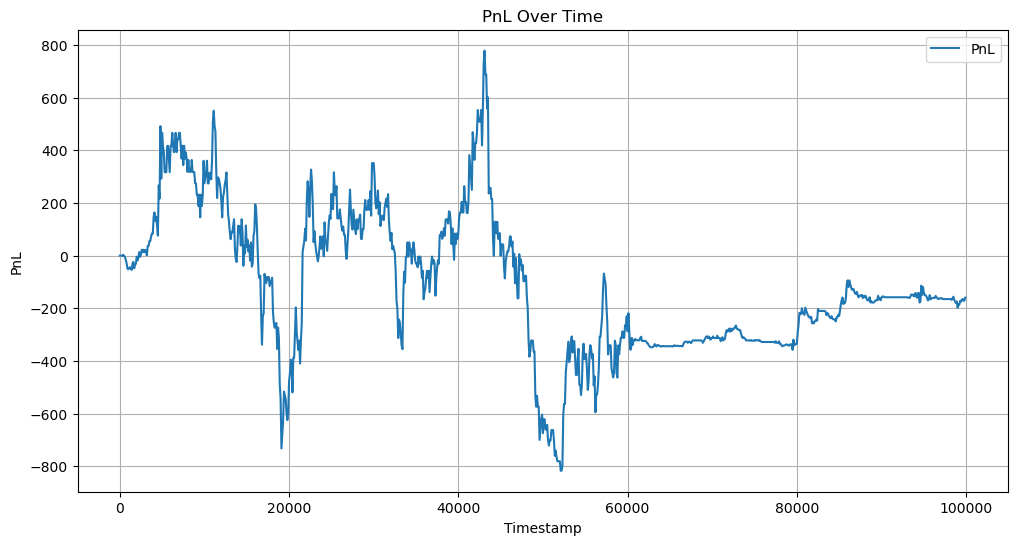

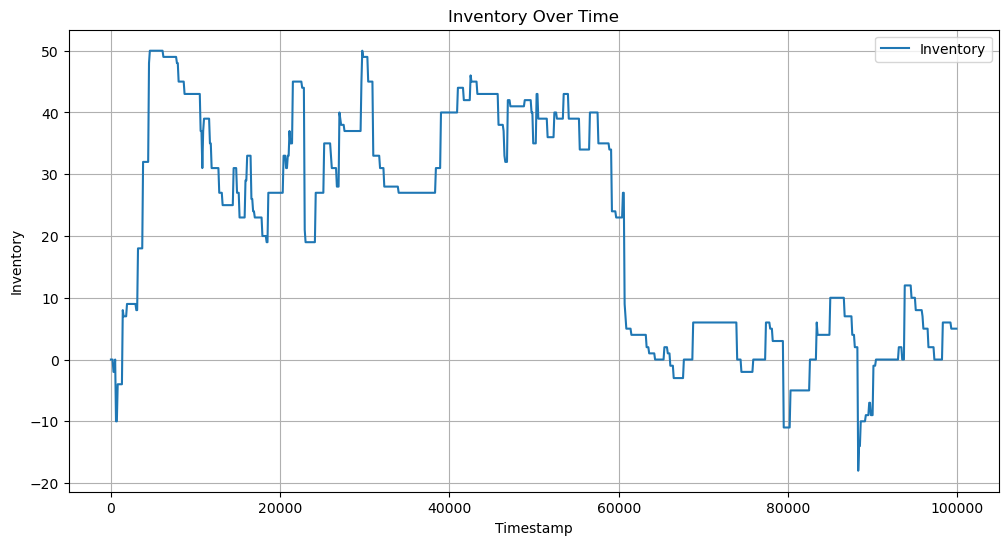

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import jsonpickle
from datamodel import OrderDepth, Order, TradingState

# ========== PARAMETER SECTION ========== #

# Backtest parameters (easy to modify)
SQUID_INK_make_width = 3.5
SQUID_INK_take_width = 1
SQUID_INK_position_limit = 50
SQUID_INK_market_make_offset = 1  # <-- This is the +1 / -1 shift you talked about

# Data file
DATA_FILE = 'Dati.csv'
moving_average_window = 10
bias_shift = 0.5

# Initialize Trader with your custom parameters


# ======================================== #

class Product:
    SQUID_INK = "SQUID_INK"

class Trader:
    def __init__(self):
        self.SQUID_INK_prices = []
        self.SQUID_INK_vwap = []
        self.LIMIT = {Product.SQUID_INK: SQUID_INK_position_limit}
        self.mid_prices = []
        self.moving_average_window = moving_average_window
        self.bias_shift = bias_shift

    def take_best_orders(self, product, fair_value, take_width, orders, order_depth, position, buy_order_volume, sell_order_volume):
        position_limit = self.LIMIT[product]
        if len(order_depth.sell_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_ask_amount = -order_depth.sell_orders[best_ask]
            if best_ask <= fair_value - take_width:
                quantity = min(best_ask_amount, position_limit - position)
                if quantity > 0:
                    orders.append(Order(product, best_ask, quantity))
                    buy_order_volume += quantity

        if len(order_depth.buy_orders) != 0:
            best_bid = max(order_depth.buy_orders.keys())
            best_bid_amount = order_depth.buy_orders[best_bid]
            if best_bid >= fair_value + take_width:
                quantity = min(best_bid_amount, position_limit + position)
                if quantity > 0:
                    orders.append(Order(product, best_bid, -quantity))
                    sell_order_volume += quantity

        return buy_order_volume, sell_order_volume

    def market_make(self, product, orders, bid, ask, position, buy_order_volume, sell_order_volume):
        buy_quantity = self.LIMIT[product] - (position + buy_order_volume)
        sell_quantity = self.LIMIT[product] + (position - sell_order_volume)

        if buy_quantity > 0:
            orders.append(Order(product, bid, buy_quantity))
        if sell_quantity > 0:
            orders.append(Order(product, ask, -sell_quantity))

        return buy_order_volume, sell_order_volume

    def clear_position_order(self, product, fair_value, orders, order_depth, position, buy_order_volume, sell_order_volume):
        fair_bid = math.floor(fair_value)
        fair_ask = math.ceil(fair_value)

        if position + buy_order_volume - sell_order_volume > 0:
            if fair_ask in order_depth.buy_orders:
                clear_quantity = min(order_depth.buy_orders[fair_ask], position)
                if clear_quantity > 0:
                    orders.append(Order(product, fair_ask, -clear_quantity))
                    sell_order_volume += clear_quantity

        if position + buy_order_volume - sell_order_volume < 0:
            if fair_bid in order_depth.sell_orders:
                clear_quantity = min(-order_depth.sell_orders[fair_bid], -position)
                if clear_quantity > 0:
                    orders.append(Order(product, fair_bid, clear_quantity))
                    buy_order_volume += clear_quantity

        return buy_order_volume, sell_order_volume

    def SQUID_INK_orders(self, order_depth, timespan, width, take_width, position):
        orders = []
        buy_order_volume = 0
        sell_order_volume = 0

        if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_bid = max(order_depth.buy_orders.keys())

            filtered_ask = [p for p in order_depth.sell_orders if abs(order_depth.sell_orders[p]) >= 15]
            filtered_bid = [p for p in order_depth.buy_orders if abs(order_depth.buy_orders[p]) >= 15]
            mm_ask = min(filtered_ask) if filtered_ask else best_ask
            mm_bid = max(filtered_bid) if filtered_bid else best_bid

            mmmid_price = (mm_ask + mm_bid) / 2
            
            # ========== MOVING AVERAGE PART ==========
            self.mid_prices.append(mmmid_price)
            if len(self.mid_prices) > self.moving_average_window:
                self.mid_prices.pop(0)
            
            moving_avg = np.mean(self.mid_prices)
            
            if mmmid_price > moving_avg:
                fair_value = mmmid_price + self.bias_shift
            else:
                fair_value = mmmid_price - self.bias_shift
            # ==========================================

            buy_order_volume, sell_order_volume = self.take_best_orders(
                Product.SQUID_INK, fair_value, take_width, orders, order_depth, position, buy_order_volume, sell_order_volume
            )

            buy_order_volume, sell_order_volume = self.clear_position_order(
                Product.SQUID_INK, fair_value, orders, order_depth, position, buy_order_volume, sell_order_volume
            )

            aaf = [p for p in order_depth.sell_orders if p > fair_value + 1]
            bbf = [p for p in order_depth.buy_orders if p < fair_value - 1]
            baaf = min(aaf) if aaf else fair_value + 2
            bbbf = max(bbf) if bbf else fair_value - 2

            buy_order_volume, sell_order_volume = self.market_make(
                Product.SQUID_INK, orders, bbbf + 1, baaf - 1, position, buy_order_volume, sell_order_volume
            )

        return orders

    def run(self, state: TradingState):
        result = {}

        if Product.SQUID_INK in state.order_depths:
            SQUID_INK_position = state.position.get(Product.SQUID_INK, 0)
            SQUID_INK_orders = self.SQUID_INK_orders(
                state.order_depths[Product.SQUID_INK],
                timespan=10,
                width=SQUID_INK_make_width,
                take_width=SQUID_INK_take_width,
                position=SQUID_INK_position
            )
            result[Product.SQUID_INK] = SQUID_INK_orders

        traderData = jsonpickle.encode({"SQUID_INK_prices": self.SQUID_INK_prices})
        conversions = 1

        return result, conversions, traderData

# ========= BACKTEST SECTION ========= #

df = pd.read_csv(DATA_FILE, sep=';')
trader = Trader()

position = {Product.SQUID_INK: 0}
cash = 0
pnl_history = []
inventory_history = []
timestamps = []

for idx, row in df[df['product'] == 'SQUID_INK'].iterrows():
    order_depth = OrderDepth()

    if not np.isnan(row['bid_price_1']):
        order_depth.buy_orders[row['bid_price_1']] = row['bid_volume_1']
    if not np.isnan(row['bid_price_2']):
        order_depth.buy_orders[row['bid_price_2']] = row['bid_volume_2']
    if not np.isnan(row['bid_price_3']):
        order_depth.buy_orders[row['bid_price_3']] = row['bid_volume_3']

    if not np.isnan(row['ask_price_1']):
        order_depth.sell_orders[row['ask_price_1']] = -row['ask_volume_1']
    if not np.isnan(row['ask_price_2']):
        order_depth.sell_orders[row['ask_price_2']] = -row['ask_volume_2']
    if not np.isnan(row['ask_price_3']):
        order_depth.sell_orders[row['ask_price_3']] = -row['ask_volume_3']

    state = TradingState(
        traderData="",
        timestamp=row['timestamp'],
        listings={},
        order_depths={Product.SQUID_INK: order_depth},
        own_trades={},
        market_trades={},
        position=position,
        observations={},
    )

    orders, conversions, traderData = trader.run(state)

    for order in orders.get(Product.SQUID_INK, []):
        if order.quantity > 0:
            best_ask = min(order_depth.sell_orders.keys())
            if order.price >= best_ask:
                quantity_filled = min(order.quantity, -order_depth.sell_orders[best_ask])
                execution_price = best_ask
                position[Product.SQUID_INK] += quantity_filled
                cash -= execution_price * quantity_filled
        elif order.quantity < 0:
            best_bid = max(order_depth.buy_orders.keys())
            if order.price <= best_bid:
                quantity_filled = min(-order.quantity, order_depth.buy_orders[best_bid])
                execution_price = best_bid
                position[Product.SQUID_INK] -= quantity_filled
                cash += execution_price * quantity_filled

    mid_price = row['mid_price']
    current_pnl = cash + position[Product.SQUID_INK] * mid_price
    pnl_history.append(current_pnl)
    inventory_history.append(position[Product.SQUID_INK])
    timestamps.append(row['timestamp'])

# ========= PLOTTING SECTION ========= #

plt.figure(figsize=(12, 6))
plt.plot(timestamps, pnl_history, label='PnL')
plt.title('PnL Over Time')
plt.xlabel('Timestamp')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(timestamps, inventory_history, label='Inventory')
plt.title('Inventory Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()

Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=20, bias_shift=0.15 => Final PnL: 500.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=20, bias_shift=0.17 => Final PnL: 500.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=20, bias_shift=0.18 => Final PnL: 500.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=20, bias_shift=0.2 => Final PnL: 500.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=22, bias_shift=0.15 => Final PnL: 512.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=22, bias_shift=0.17 => Final PnL: 512.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=22, bias_shift=0.18 => Final PnL: 512.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_window=22, bias_shift=0.2 => Final PnL: 512.5
Tested: make_width=0.3, take_width=0.3, pos_limit=15, offset=0.1, MA_windo

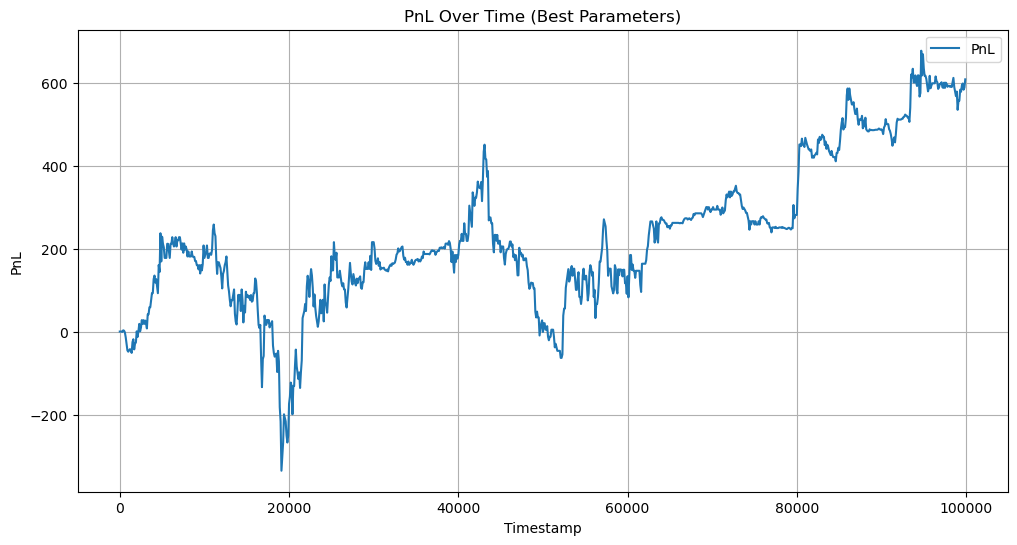

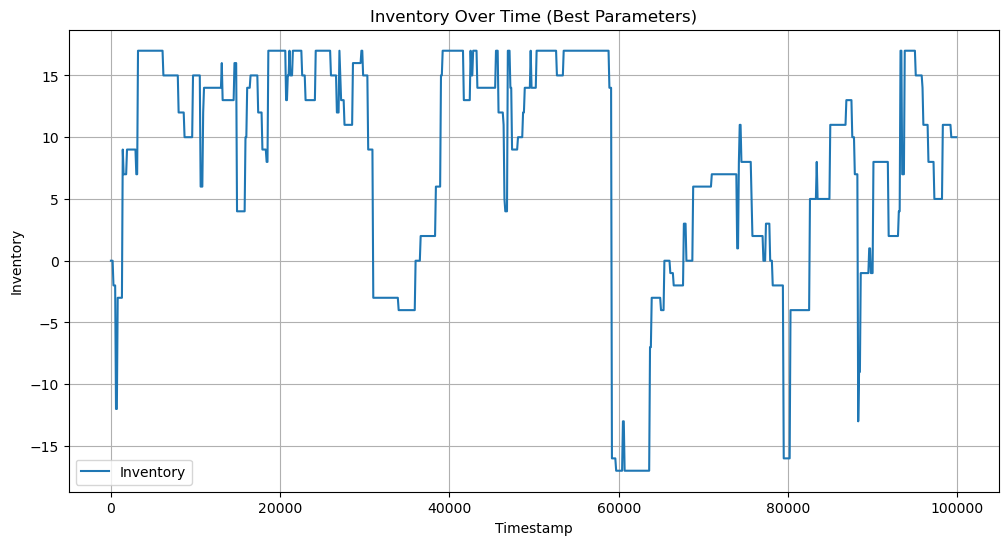

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import jsonpickle
from itertools import product
from datamodel import OrderDepth, Order, TradingState

# ========== PARAMETER SECTION ========== #

# Candidate values for grid search:
make_width_grid = [0.3, 0.4, 0.5, 0.6]
take_width_grid = [0.30, 0.35, 0.4]
position_limit_grid = [15, 17,20]
market_make_offset_grid = [0.1, 0.2,0.3]
moving_average_window_grid = [20,22,25,27,30]
bias_shift_grid = [0.15, 0.17, 0.18, 0.2]

# Data file
DATA_FILE = 'Dati.csv'
df = pd.read_csv(DATA_FILE, sep=';')

# ======================================== #

class Product:
    SQUID_INK = "SQUID_INK"

class Trader:
    def __init__(self):
        # Global parameters (will be updated in the grid search loop)
        self.SQUID_INK_prices = []
        self.SQUID_INK_vwap = []
        self.LIMIT = {Product.SQUID_INK: SQUID_INK_position_limit}  # Uses global variable SQUID_INK_position_limit
        self.mid_prices = []
        self.moving_average_window = moving_average_window   # global moving_average_window
        self.bias_shift = bias_shift  # global bias_shift

    def take_best_orders(self, product, fair_value, take_width, orders, order_depth, position, buy_order_volume, sell_order_volume):
        position_limit = self.LIMIT[product]
        if len(order_depth.sell_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_ask_amount = -order_depth.sell_orders[best_ask]
            if best_ask <= fair_value - take_width:
                quantity = min(best_ask_amount, position_limit - position)
                if quantity > 0:
                    orders.append(Order(product, best_ask, quantity))
                    buy_order_volume += quantity

        if len(order_depth.buy_orders) != 0:
            best_bid = max(order_depth.buy_orders.keys())
            best_bid_amount = order_depth.buy_orders[best_bid]
            if best_bid >= fair_value + take_width:
                quantity = min(best_bid_amount, position_limit + position)
                if quantity > 0:
                    orders.append(Order(product, best_bid, -quantity))
                    sell_order_volume += quantity

        return buy_order_volume, sell_order_volume

    def market_make(self, product, orders, bid, ask, position, buy_order_volume, sell_order_volume):
        buy_quantity = self.LIMIT[product] - (position + buy_order_volume)
        sell_quantity = self.LIMIT[product] + (position - sell_order_volume)

        if buy_quantity > 0:
            orders.append(Order(product, bid, buy_quantity))
        if sell_quantity > 0:
            orders.append(Order(product, ask, -sell_quantity))

        return buy_order_volume, sell_order_volume

    def clear_position_order(self, product, fair_value, orders, order_depth, position, buy_order_volume, sell_order_volume):
        fair_bid = math.floor(fair_value)
        fair_ask = math.ceil(fair_value)

        if position + buy_order_volume - sell_order_volume > 0:
            if fair_ask in order_depth.buy_orders:
                clear_quantity = min(order_depth.buy_orders[fair_ask], position)
                if clear_quantity > 0:
                    orders.append(Order(product, fair_ask, -clear_quantity))
                    sell_order_volume += clear_quantity

        if position + buy_order_volume - sell_order_volume < 0:
            if fair_bid in order_depth.sell_orders:
                clear_quantity = min(-order_depth.sell_orders[fair_bid], -position)
                if clear_quantity > 0:
                    orders.append(Order(product, fair_bid, clear_quantity))
                    buy_order_volume += clear_quantity

        return buy_order_volume, sell_order_volume

    def SQUID_INK_orders(self, order_depth, timespan, width, take_width, position):
        orders = []
        buy_order_volume = 0
        sell_order_volume = 0

        if len(order_depth.sell_orders) != 0 and len(order_depth.buy_orders) != 0:
            best_ask = min(order_depth.sell_orders.keys())
            best_bid = max(order_depth.buy_orders.keys())

            filtered_ask = [p for p in order_depth.sell_orders if abs(order_depth.sell_orders[p]) >= 15]
            filtered_bid = [p for p in order_depth.buy_orders if abs(order_depth.buy_orders[p]) >= 15]
            mm_ask = min(filtered_ask) if filtered_ask else best_ask
            mm_bid = max(filtered_bid) if filtered_bid else best_bid

            mmmid_price = (mm_ask + mm_bid) / 2
            
            # ========== MOVING AVERAGE PART ==========
            self.mid_prices.append(mmmid_price)
            if len(self.mid_prices) > self.moving_average_window:
                self.mid_prices.pop(0)
            
            moving_avg = np.mean(self.mid_prices)
            
            if mmmid_price > moving_avg:
                fair_value = mmmid_price + self.bias_shift
            else:
                fair_value = mmmid_price - self.bias_shift
            # ==========================================

            buy_order_volume, sell_order_volume = self.take_best_orders(
                Product.SQUID_INK, fair_value, take_width, orders, order_depth, position, buy_order_volume, sell_order_volume
            )

            buy_order_volume, sell_order_volume = self.clear_position_order(
                Product.SQUID_INK, fair_value, orders, order_depth, position, buy_order_volume, sell_order_volume
            )

            aaf = [p for p in order_depth.sell_orders if p > fair_value + 1]
            bbf = [p for p in order_depth.buy_orders if p < fair_value - 1]
            baaf = min(aaf) if aaf else fair_value + 2
            bbbf = max(bbf) if bbf else fair_value - 2

            buy_order_volume, sell_order_volume = self.market_make(
                Product.SQUID_INK, orders, bbbf + 1, baaf - 1, position, buy_order_volume, sell_order_volume
            )

        return orders

    def run(self, state: TradingState):
        result = {}

        if Product.SQUID_INK in state.order_depths:
            SQUID_INK_position = state.position.get(Product.SQUID_INK, 0)
            SQUID_INK_orders = self.SQUID_INK_orders(
                state.order_depths[Product.SQUID_INK],
                timespan=10,
                width=SQUID_INK_make_width,
                take_width=SQUID_INK_take_width,
                position=SQUID_INK_position
            )
            result[Product.SQUID_INK] = SQUID_INK_orders

        traderData = jsonpickle.encode({"SQUID_INK_prices": self.SQUID_INK_prices})
        conversions = 1

        return result, conversions, traderData

# ========= BACKTEST FUNCTION ========= #

def run_backtest():
    position = {Product.SQUID_INK: 0}
    cash = 0
    pnl_history = []
    inventory_history = []
    timestamps = []
    
    trader = Trader()
    
    for idx, row in df[df['product'] == 'SQUID_INK'].iterrows():
        order_depth = OrderDepth()

        if not np.isnan(row['bid_price_1']):
            order_depth.buy_orders[row['bid_price_1']] = row['bid_volume_1']
        if not np.isnan(row['bid_price_2']):
            order_depth.buy_orders[row['bid_price_2']] = row['bid_volume_2']
        if not np.isnan(row['bid_price_3']):
            order_depth.buy_orders[row['bid_price_3']] = row['bid_volume_3']

        if not np.isnan(row['ask_price_1']):
            order_depth.sell_orders[row['ask_price_1']] = -row['ask_volume_1']
        if not np.isnan(row['ask_price_2']):
            order_depth.sell_orders[row['ask_price_2']] = -row['ask_volume_2']
        if not np.isnan(row['ask_price_3']):
            order_depth.sell_orders[row['ask_price_3']] = -row['ask_volume_3']

        state = TradingState(
            traderData="",
            timestamp=row['timestamp'],
            listings={},
            order_depths={Product.SQUID_INK: order_depth},
            own_trades={},
            market_trades={},
            position=position,
            observations={},
        )

        orders, conversions, traderData = trader.run(state)

        for order in orders.get(Product.SQUID_INK, []):
            if order.quantity > 0:
                best_ask = min(order_depth.sell_orders.keys())
                if order.price >= best_ask:
                    quantity_filled = min(order.quantity, -order_depth.sell_orders[best_ask])
                    execution_price = best_ask
                    position[Product.SQUID_INK] += quantity_filled
                    cash -= execution_price * quantity_filled
            elif order.quantity < 0:
                best_bid = max(order_depth.buy_orders.keys())
                if order.price <= best_bid:
                    quantity_filled = min(-order.quantity, order_depth.buy_orders[best_bid])
                    execution_price = best_bid
                    position[Product.SQUID_INK] -= quantity_filled
                    cash += execution_price * quantity_filled

        mid_price = row['mid_price']
        current_pnl = cash + position[Product.SQUID_INK] * mid_price
        pnl_history.append(current_pnl)
        inventory_history.append(position[Product.SQUID_INK])
        timestamps.append(row['timestamp'])
        
    return pnl_history, inventory_history, timestamps

# ========= GRID SEARCH ========= #

best_pnl = -float('inf')
best_params = None

for (mw_val, tw_val, pos_lim, mm_offset, ma_window_val, b_shift_val) in product(
    make_width_grid, take_width_grid, position_limit_grid, market_make_offset_grid, moving_average_window_grid, bias_shift_grid):

    # Update global parameters (used by Trader and run in backtest)
    SQUID_INK_make_width = mw_val
    SQUID_INK_take_width = tw_val
    SQUID_INK_position_limit = pos_lim
    SQUID_INK_market_make_offset = mm_offset
    moving_average_window = ma_window_val
    bias_shift = b_shift_val

    pnl_history, inventory_history, timestamps = run_backtest()
    
    # Use the final PnL value as a metric (you can also use average or max)
    final_pnl = pnl_history[-1] if pnl_history else -float('inf')
    
    if final_pnl > best_pnl:
        best_pnl = final_pnl
        best_params = (mw_val, tw_val, pos_lim, mm_offset, ma_window_val, b_shift_val)
    
    print(f"Tested: make_width={mw_val}, take_width={tw_val}, pos_limit={pos_lim}, offset={mm_offset}, "
          f"MA_window={ma_window_val}, bias_shift={b_shift_val} => Final PnL: {final_pnl}")

print("\nBest Final PnL:", best_pnl)
print("Best Parameters (make_width, take_width, pos_limit, offset, MA_window, bias_shift):", best_params)

# ========= PLOTTING FOR BEST PARAMETERS ========= #

# After finding best parameters, update globals and run backtest one more time to plot results
(SQUID_INK_make_width, SQUID_INK_take_width, SQUID_INK_position_limit, 
 SQUID_INK_market_make_offset, moving_average_window, bias_shift) = best_params

pnl_history, inventory_history, timestamps = run_backtest()

plt.figure(figsize=(12, 6))
plt.plot(timestamps, pnl_history, label='PnL')
plt.title('PnL Over Time (Best Parameters)')
plt.xlabel('Timestamp')
plt.ylabel('PnL')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(timestamps, inventory_history, label='Inventory')
plt.title('Inventory Over Time (Best Parameters)')
plt.xlabel('Timestamp')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()